In [1]:
import pandas as pd
import DataLoading
import torch
import matplotlib.pyplot as plt
import NN_evaluation
import numpy as np 

In [2]:
sc = "sc01"
period = "2030"
case= "3-bus"
folder = f"../Data/{case}_DC_fy/"

all_executions = DataLoading.list_executions(folder=folder,per = period,sc=sc)
te_s = 0.3
val_s = 0.3
dfs_in, dfs_out, dfs_inter = DataLoading.load_data_ext_out(folder, all_executions, period, sc, ["PowerFlow"],"SystemCosts")
dfs_inter_j = DataLoading.join_frames_inter_layer(dfs_inter,all_executions)
dfs_inter_j = DataLoading.trim_columns_to_common(dfs_inter_j)
# Convert to pytorch tensors
ts_in, ts_out, ts_inter = DataLoading.split_tr_val_te_ext_out(dfs_in, dfs_out, dfs_inter_j, all_executions, te_s, val_s)
d_ft_in, d_ft_out, d_ft_inter,maxs = DataLoading.concat_and_normalize_ext_out(ts_in, ts_out, ts_inter, all_executions)

input_size = dfs_in["Network_Existing_Generation_Full"].shape[1]
inter_size = dfs_inter_j["Network_Existing_Generation_Full"].shape[1]

t_in_fy, t_out_fy, t_inter_fy, maxs = DataLoading.concat_all_exec_fy(dfs_in=dfs_in, dfs_out=dfs_out, dfs_inter_j=dfs_inter_j,executions=all_executions,normalize_out=True)


input_f_sc01_Network_Existing_Generation_Full_2030.csv
14
input_f_sc01_Network_Full_Generation_Full_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_2_cac1_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_2_cac2_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_2_cac3_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_3_cac1_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_3_cac2_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_3_cac3_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_2_Node_3_cac1_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_2_Node_3_cac2_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_2_Node_3_cac3_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_2_cac1_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_2_cac2_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_2_cac3_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_3_cac1_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_No

In [3]:
#Calculate some overall metrics such as variance 
torch.mean(t_in_fy,axis = 0)
print("Input standard dev:", torch.std(t_in_fy,axis = 0))

torch.mean(t_inter_fy,axis = 0)
print("Intermediate layer standard dev:",torch.std(t_inter_fy,axis = 0))

print("Output standard dev:",torch.std(t_out_fy,axis = 0))
torch.mean(t_out_fy,axis = 0)


Input standard dev: tensor([0.1405, 0.1122, 0.1228, 0.3096, 0.2013, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000], dtype=torch.float64)
Intermediate layer standard dev: tensor([0.4689, 0.2525, 0.2630], dtype=torch.float64)
Output standard dev: tensor(0.0932, dtype=torch.float64)


tensor(0.2733, dtype=torch.float64)

In [4]:
np_out_original_full = t_out_fy.numpy()*maxs["out"].numpy()

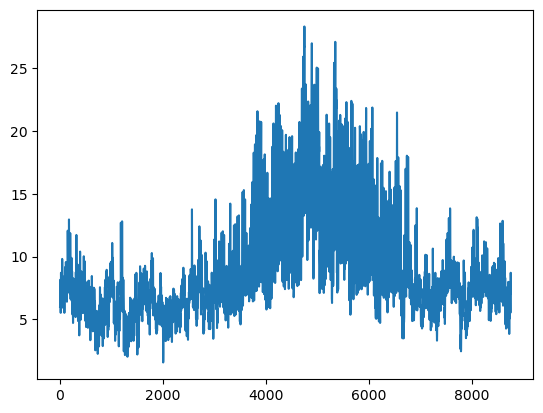

In [5]:
plt.plot(np_out_original_full[0:8760])

tensor(0.0781, dtype=torch.float64) tensor(2.0330e-13, dtype=torch.float64) tensor(0.1393, dtype=torch.float64)


{'whiskers': [<matplotlib.lines.Line2D at 0x1f7154a1f00>,
 'caps': [<matplotlib.lines.Line2D at 0x1f7154a2440>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f7154a1c60>],
 'medians': [<matplotlib.lines.Line2D at 0x1f7154a2980>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f7154a2c20>],
 'means': []}

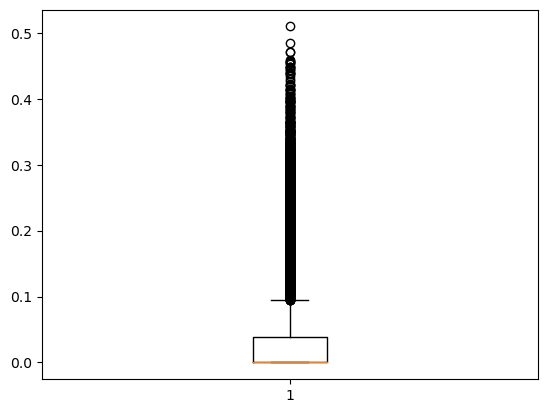

In [6]:
#Look at the average difference and percentual deviation incurred by installing all candidates
existing_actual = NN_evaluation.get_actual_from_dfs_out(all_executions[0],dfs_out)/maxs["out"]
full_actual = NN_evaluation.get_actual_from_dfs_out(all_executions[1],dfs_out)/maxs["out"]

differences = existing_actual - full_actual
deviation_existing = torch.div(differences,existing_actual) 

print(torch.mean(deviation_existing),torch.median(deviation_existing), torch.std(deviation_existing))
plt.boxplot(differences.detach().numpy())
#plt.boxplot(deviation_existing.detach().numpy())

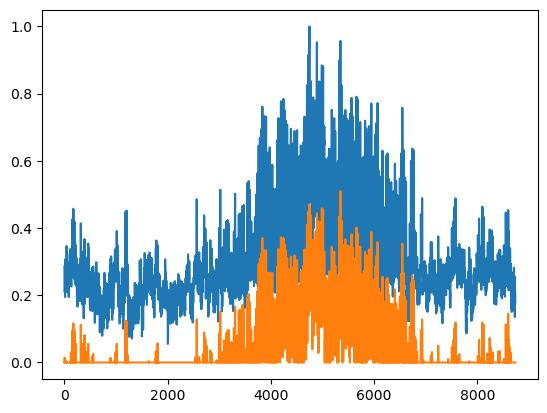

In [8]:
plt.plot(existing_actual)
#plt.plot(full_actual)
plt.plot(differences)

In [9]:
#Collect difference and deviation incurred by individual candidates in dataframe
ics = DataLoading.list_investments_candidates_from_execs(executions=all_executions)
df_lb = pd.DataFrame()
for ic in ics:
    ix_P = [i for i, string in enumerate(all_executions) if ic in string and "PINT" in string]
    ix_T = [i for i, string in enumerate(all_executions) if ic in string and "TOOT" in string]
    ex_P  = all_executions[ix_P[0]]
    ex_T = all_executions[ix_T[0]]

    ex_actual_P = NN_evaluation.get_actual_from_dfs_out(ex_P,dfs_out)/maxs["out"]
    ex_actual_T = NN_evaluation.get_actual_from_dfs_out(ex_T,dfs_out)/maxs["out"]

    lb_P = existing_actual -ex_actual_P
    lb_T = - (full_actual - ex_actual_T)

    lb = (lb_P + lb_T)/2
    df_lb[ic] = lb
    #ic,ex_P,ex_T,lb.sum()
df_lb_dev = df_lb.div(existing_actual,axis=0)

In [135]:
#Model deviations
hyperloop_name = "rand_hours_3-bus_DC_0.25_v0.33_PF_0_20"

df_losses = pd.read_csv(f"Loss_results_csv/{hyperloop_name}.csv",index_col=0)
f = df_losses.Nb_hours_used <=2000

loss_to_sort = "Te_l_mse"
xth_best = 1

row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
if row.Sel_method.item() == "Hours": 
    hyperloop_name = "rand_Hours_3-bus_DC_0.25_v0.33_PF_0_20"
elif row.Sel_method.item() == "Days":
    hyperloop_name = "rand_Days_3-bus_DC_0.25_v0.33_PF_0_20"

m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=False)
prediction = m(t_in_fy.float())[0].squeeze().detach().numpy()

diff = prediction - t_out_fy.numpy().transpose()
dev = diff/prediction

[28, 42, 8, 3, 1]
OE_1200hours_(3, 1)h_256e_0.00125lr_0dor_Falsero_64bs_0ill_FalseMAE min_val
trained_models/rand_Hours_3-bus_DC_0.25_v0.33_PF_0_20/min_val/model_OE_1200hours_(3, 1)h_256e_0.00125lr_0dor_Falsero_64bs_0ill_FalseMAE.pth


{'whiskers': [<matplotlib.lines.Line2D at 0x1f71dda40d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1f71dda4610>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f72467fdf0>],
 'medians': [<matplotlib.lines.Line2D at 0x1f71dda4b50>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f71dda4df0>],
 'means': []}

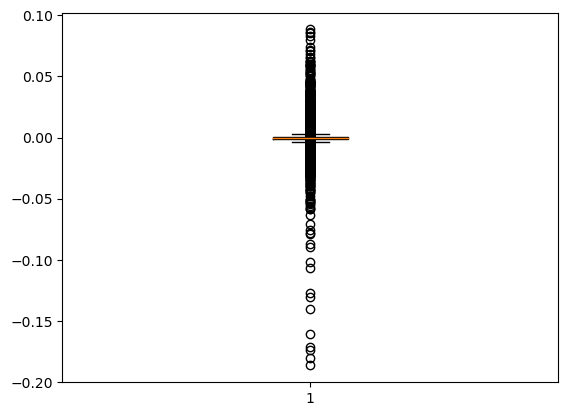

In [80]:
plt.boxplot(dev)

In [81]:
def get_exec_indices_PT(ic,all_executions):
    ix_P = [i for i, string in enumerate(all_executions) if ic in string and "PINT" in string]
    ix_T = [i for i, string in enumerate(all_executions) if ic in string and "TOOT" in string]
    ex_P  = all_executions[ix_P[0]]
    ex_T = all_executions[ix_T[0]]
    return ex_P,ex_T
    
def get_lb_actual_PT(ic,dfs_out,all_executions,maxs): 
    ex_P,ex_T = get_exec_indices_PT(ic,all_executions)

    ex_actual_P = NN_evaluation.get_actual_from_dfs_out(ex_P,dfs_out)/maxs["out"]
    ex_actual_T = NN_evaluation.get_actual_from_dfs_out(ex_T,dfs_out)/maxs["out"]

    lb_P = existing_actual -ex_actual_P
    lb_T = - (full_actual - ex_actual_T)

    lb = (lb_P + lb_T)/2
    return lb
def get_lb_estimated_PT(m,ic,dfs_in,all_executions,maxs):
    ix_P = [i for i, string in enumerate(all_executions) if ic in string and "PINT" in string]
    ix_T = [i for i, string in enumerate(all_executions) if ic in string and "TOOT" in string]
    ex_P  = all_executions[ix_P[0]]
    ex_T = all_executions[ix_T[0]]


    est_ic_P = NN_evaluation.get_NN_estimates_from_dfs_in(m,ex_P,dfs_in,maxs)
    est_ic_T = NN_evaluation.get_NN_estimates_from_dfs_in(m,ex_T,dfs_in,maxs)

    est_exis = NN_evaluation.get_NN_estimates_from_dfs_in(m,all_executions[0],dfs_in,maxs)
    est_full = NN_evaluation.get_NN_estimates_from_dfs_in(m,all_executions[1],dfs_in,maxs)

    lb_P =  est_exis-est_ic_P
    lb_T = - (est_full - est_ic_T)
    lb = (lb_P + lb_T)/2
    return lb

In [120]:
ic_i=7
get_lb_actual_PT(ic = ics[ic_i],dfs_out=dfs_out,all_executions=all_executions,maxs = maxs).sum(),get_lb_estimated_PT(m=m,ic=ics[ic_i],dfs_in=dfs_in,all_executions=all_executions,maxs=maxs).sum()

(tensor(172.8614, dtype=torch.float64), 172.09692)

In [121]:
ix_P = [i for i, string in enumerate(all_executions) if ic in string and "PINT" in string]
ix_T = [i for i, string in enumerate(all_executions) if ic in string and "TOOT" in string]
ex_P  = all_executions[ix_P[0]]
ex_T = all_executions[ix_T[0]]


est_ic_P = NN_evaluation.get_NN_estimates_from_dfs_in(m,ex_P,dfs_in,maxs)
est_ic_T = NN_evaluation.get_NN_estimates_from_dfs_in(m,ex_T,dfs_in,maxs)

est_exis = NN_evaluation.get_NN_estimates_from_dfs_in(m,all_executions[0],dfs_in,maxs)
est_full = NN_evaluation.get_NN_estimates_from_dfs_in(m,all_executions[1],dfs_in,maxs)

lb_P =  est_exis-est_ic_P
lb_T = - (est_full - est_ic_T)
lb = (lb_P + lb_T)/2
lb.sum()

183.2474

In [138]:
#Collect both actual and estimated line benefits incurred by individual candidates in dataframe
ics = DataLoading.list_investments_candidates_from_execs(executions=all_executions)
df_lb = pd.DataFrame()
for ic in ics:
    lb_actual = get_lb_actual_PT(ic = ic,dfs_out=dfs_out,all_executions=all_executions,maxs = maxs)
    lb_est = get_lb_estimated_PT(m=m,ic=ic,dfs_in=dfs_in,all_executions=all_executions,maxs=maxs)

    df_lb[f"{ic}_actual"] = lb_actual
    df_lb[f"{ic}_estimate"] = lb_est

In [139]:
df_lb.sum()

Network_Line_In_Node_1_Node_2_cac1_actual       30.695224
Network_Line_In_Node_1_Node_2_cac1_estimate     38.489174
Network_Line_In_Node_1_Node_2_cac2_actual       51.078886
Network_Line_In_Node_1_Node_2_cac2_estimate     48.071980
Network_Line_In_Node_1_Node_2_cac3_actual       76.141324
Network_Line_In_Node_1_Node_2_cac3_estimate     78.914284
Network_Line_In_Node_1_Node_3_cac1_actual       61.406775
Network_Line_In_Node_1_Node_3_cac1_estimate     63.040558
Network_Line_In_Node_1_Node_3_cac2_actual       96.492366
Network_Line_In_Node_1_Node_3_cac2_estimate     96.046082
Network_Line_In_Node_1_Node_3_cac3_actual      124.999348
Network_Line_In_Node_1_Node_3_cac3_estimate    125.377502
Network_Line_In_Node_2_Node_3_cac1_actual      123.089159
Network_Line_In_Node_2_Node_3_cac1_estimate    120.796242
Network_Line_In_Node_2_Node_3_cac2_actual      172.861409
Network_Line_In_Node_2_Node_3_cac2_estimate    172.595261
Network_Line_In_Node_2_Node_3_cac3_actual      184.636053
Network_Line_I

<Axes: xlabel='Network_Line_In_Node_2_Node_3_cac3_actual', ylabel='Network_Line_In_Node_2_Node_3_cac3_estimate'>

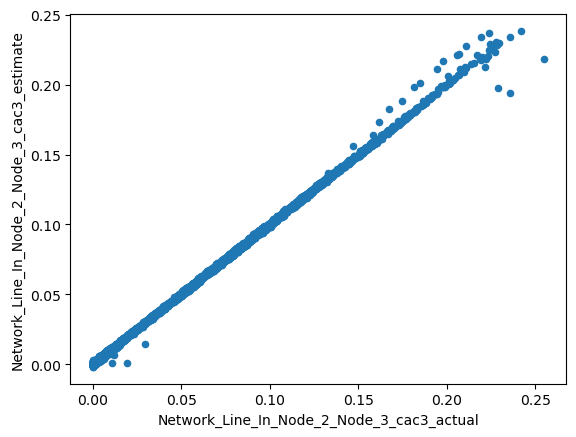

In [140]:
candidate = "Network_Line_In_Node_2_Node_3_cac3"
df_lb.plot.scatter(x=f"{candidate}_actual",y=f"{candidate}_estimate")